# LightGBM Model

This script implements a machine learning model to forecast daily unit sales using LightGBM,
based on Walmart's hierarchical sales data as provided in the M5 Forecasting Challenge.

The model includes:
- Data loading and cleaning (from preprocessed pickle file)
- Label encoding of categorical features
- Feature construction including lag, rolling averages, and holiday flags
- Model training using LightGBM with early stopping and evaluation
- Visualization of feature importance, error distribution, and actual vs predicted values

The trained model is saved as a LightGBM text file for further deployment or analysis.

In [1]:
import pandas as pd
import lightgbm as lgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import LabelEncoder
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [2]:
# Load preprocessed data
print("Loading preprocessed data...")
full_df = pd.read_pickle('Dataset/processed_sales_data.pkl')
print(f"Data shape: {full_df.shape}")

# Drop rows with NaN (due to lag/rolling features)
print("Dropping rows with NaN values...")
model_df = full_df.dropna(subset=['sales_lag_7', 'rolling_mean_7', 'price_change'])
print(f"Remaining data shape: {model_df.shape}")

Loading preprocessed data...
Data shape: (58327370, 29)
Dropping rows with NaN values...
Remaining data shape: (45931875, 29)


In [3]:
# Label encode categorical features
print("Encoding categorical features using LabelEncoder...")
categorical_cols = ['item_id', 'dept_id', 'cat_id', 'store_id', 'state_id']
for col in categorical_cols:
    encoder = LabelEncoder()
    model_df[col] = encoder.fit_transform(model_df[col])

Encoding categorical features using LabelEncoder...


/var/folders/zv/n9dl8wj94hqfxs9swp91wt0w0000gn/T/ipykernel_10742/3460212456.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df[col] = encoder.fit_transform(model_df[col])
/var/folders/zv/n9dl8wj94hqfxs9swp91wt0w0000gn/T/ipykernel_10742/3460212456.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  model_df[col] = encoder.fit_transform(model_df[col])
/var/folders/zv/n9dl8wj94hqfxs9swp91wt0w0000gn/T/ipykernel_10742/3460212456.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a 

In [4]:
# Define features
features = [
    'item_id', 'dept_id', 'cat_id', 'store_id', 'state_id',
    'day_of_week', 'month', 'year', 'is_weekend', 'is_us_holiday',
    'sales_lag_7', 'rolling_mean_7', 'price_change'
]
print(f"Total number of features: {len(features)}")

Total number of features: 13


In [5]:
# Prepare training and validation data
print("Splitting data into training and validation sets...")
X = model_df[features]
y = model_df['sales']
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)
print(f"Training samples: {X_train.shape[0]}, Validation samples: {X_val.shape[0]}")

Splitting data into training and validation sets...
Training samples: 36745500, Validation samples: 9186375


In [6]:
# LightGBM dataset format
train_data = lgb.Dataset(X_train, label=y_train, categorical_feature=categorical_cols)
val_data = lgb.Dataset(X_val, label=y_val, reference=train_data, categorical_feature=categorical_cols)

In [7]:
# Train model
print("Starting LightGBM training...")
params = {
    'objective': 'regression',
    'metric': 'rmse',
    'boosting_type': 'gbdt',
    'verbosity': -1,
    'learning_rate': 0.05,
    'num_leaves': 31,
    'feature_fraction': 0.8
}

model = lgb.train(params,
                  train_data,
                  valid_sets=[train_data, val_data],
                  num_boost_round=1000,
                  callbacks=[
                      lgb.early_stopping(stopping_rounds=50),
                      lgb.log_evaluation(period=100)
                  ])

Starting LightGBM training...
Training until validation scores don't improve for 50 rounds
[100]	training's rmse: 2.39041	valid_1's rmse: 2.36933
[200]	training's rmse: 2.35814	valid_1's rmse: 2.34458
[300]	training's rmse: 2.34283	valid_1's rmse: 2.33503
[400]	training's rmse: 2.33212	valid_1's rmse: 2.32926
[500]	training's rmse: 2.32336	valid_1's rmse: 2.32468
[600]	training's rmse: 2.31589	valid_1's rmse: 2.3211
[700]	training's rmse: 2.3096	valid_1's rmse: 2.31813
[800]	training's rmse: 2.30423	valid_1's rmse: 2.31605
[900]	training's rmse: 2.29943	valid_1's rmse: 2.31443
[1000]	training's rmse: 2.295	valid_1's rmse: 2.31281
Did not meet early stopping. Best iteration is:
[1000]	training's rmse: 2.295	valid_1's rmse: 2.31281


In [8]:
# Predict and evaluate
print("Evaluating model on validation set...")
preds = model.predict(X_val, num_iteration=model.best_iteration)
rmse = np.sqrt(mean_squared_error(y_val, preds))
print(f"Validation RMSE: {rmse:.4f}")

Evaluating model on validation set...
Validation RMSE: 2.3128


In [9]:
# Save model
print("Saving model to file: lgbm_m5_model.txt")
model.save_model('lgbm_m5_model.txt')

Saving model to file: lgbm_m5_model.txt


Plotting feature importance...


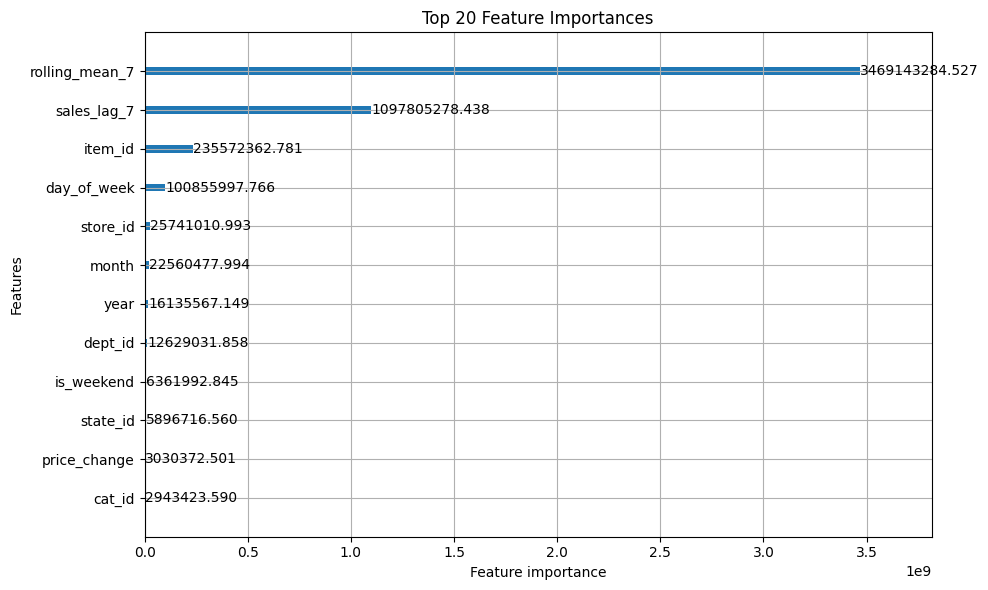

In [10]:
# Plot feature importance
print("Plotting feature importance...")
lgb.plot_importance(model, max_num_features=20, importance_type='gain', figsize=(10, 6))
plt.title("Top 20 Feature Importances")
plt.tight_layout()
plt.savefig("feature_importance.png")
plt.show()

Plotting error distribution...


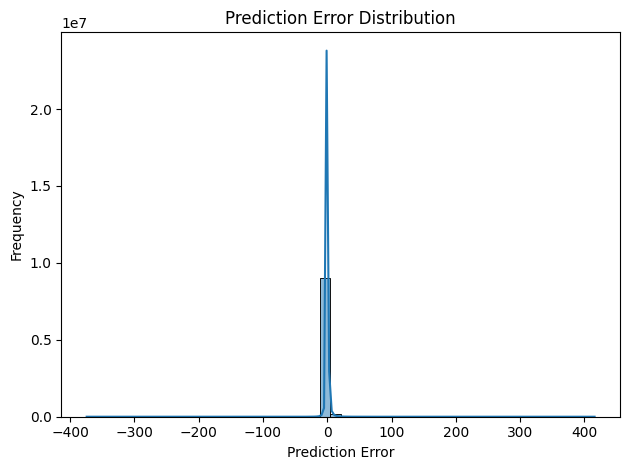

In [11]:
# Plot error distribution
print("Plotting error distribution...")
errors = y_val - preds
sns.histplot(errors, bins=50, kde=True)
plt.title("Prediction Error Distribution")
plt.xlabel("Prediction Error")
plt.ylabel("Frequency")
plt.tight_layout()
plt.savefig("error_distribution.png")
plt.show()

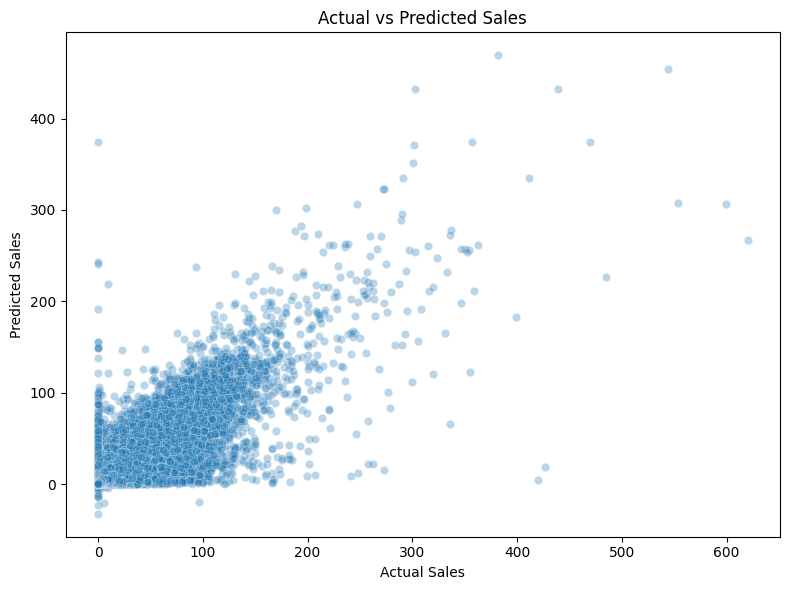

In [12]:
# Scatter actual vs predicted
plt.figure(figsize=(8, 6))
sns.scatterplot(x=y_val, y=preds, alpha=0.3)
plt.xlabel("Actual Sales")
plt.ylabel("Predicted Sales")
plt.title("Actual vs Predicted Sales")
plt.tight_layout()
plt.savefig("actual_vs_predicted.png")
plt.show()